In [1]:
#importing necessary packages
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.pyplot import savefig

In [2]:
# Load the dataset
# fetch dataset 
rt_iot2022 = fetch_ucirepo(id=942) 
  
# data (as pandas dataframes) 
X = rt_iot2022.data.features 
y = rt_iot2022.data.targets 

data = pd.concat([X,y], axis=1)
# Display the first few rows of the dataset
data.head()

,id.orig_p,id.resp_p,proto,service,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,...,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,Attack_type
0,38667,1883,tcp,mqtt,32.011598,9,5,3,3,0.281148,...,0.0,29729182.96,29729182.96,29729182.96,29729182.96,0.0,64240,26847,502,MQTT_Publish
1,51143,1883,tcp,mqtt,31.883584,9,5,3,3,0.282277,...,0.0,29855277.06,29855277.06,29855277.06,29855277.06,0.0,64240,26847,502,MQTT_Publish
2,44761,1883,tcp,mqtt,32.124053,9,5,3,3,0.280164,...,0.0,29842149.02,29842149.02,29842149.02,29842149.02,0.0,64240,26847,502,MQTT_Publish
3,60893,1883,tcp,mqtt,31.961063,9,5,3,3,0.281593,...,0.0,29913774.97,29913774.97,29913774.97,29913774.97,0.0,64240,26847,502,MQTT_Publish
4,51087,1883,tcp,mqtt,31.902362,9,5,3,3,0.282111,...,0.0,29814704.90,29814704.90,29814704.90,29814704.90,0.0,64240,26847,502,MQTT_Publish


## Data Cleaning -- Kimberly

In [3]:
# Identify columns with a single unique value
single_value_columns = data.nunique()
single_value_columns = single_value_columns[single_value_columns <= 1].index.tolist()

# Potentially irrelevant columns
potentially_irrelevant_columns = single_value_columns  # 'Unnamed: 0' seems like an identifier

# Remove the identified irrelevant columns
cleaned_data = data.drop(columns=potentially_irrelevant_columns)

# Display the first few rows of the cleaned dataset to confirm removal
cleaned_data.head()

,id.orig_p,id.resp_p,proto,service,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,...,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,Attack_type
0,38667,1883,tcp,mqtt,32.011598,9,5,3,3,0.281148,...,0.0,29729182.96,29729182.96,29729182.96,29729182.96,0.0,64240,26847,502,MQTT_Publish
1,51143,1883,tcp,mqtt,31.883584,9,5,3,3,0.282277,...,0.0,29855277.06,29855277.06,29855277.06,29855277.06,0.0,64240,26847,502,MQTT_Publish
2,44761,1883,tcp,mqtt,32.124053,9,5,3,3,0.280164,...,0.0,29842149.02,29842149.02,29842149.02,29842149.02,0.0,64240,26847,502,MQTT_Publish
3,60893,1883,tcp,mqtt,31.961063,9,5,3,3,0.281593,...,0.0,29913774.97,29913774.97,29913774.97,29913774.97,0.0,64240,26847,502,MQTT_Publish
4,51087,1883,tcp,mqtt,31.902362,9,5,3,3,0.282111,...,0.0,29814704.90,29814704.90,29814704.90,29814704.90,0.0,64240,26847,502,MQTT_Publish


## Perform PCA Analysis - Kimberly

In [4]:
data_encoded = pd.get_dummies(cleaned_data, columns=['proto', 'service'])

# Assuming `data_encoded` now holds fully numerical dataset
X = data_encoded.drop('Attack_type', axis=1)  # Exclude the target variable for PCA
y = data_encoded['Attack_type']  # This assumes `Attack_type` has been properly converted to numerical format

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=0.95)  # Adjust based on desired variance retention
X_pca = pca.fit_transform(X_scaled)

# Output the results
print("Number of components kept: ", pca.n_components_)
print("Explained variance ratio: ", pca.explained_variance_ratio_.sum())

Number of components kept:  32
Explained variance ratio:  0.9549256505614501


## SVM Analysis -- Emily

In [5]:
from sklearn.svm import SVC

In [6]:
## Test different kernels
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for k in kernels:
    svc = SVC(kernel= k)
    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    print("Results for Kernel =", k)
    print(f"Accuracy: {accuracy}")
    print(classification_report(y_test, y_pred))

Results for Kernel = linear
Accuracy: 0.9902940220922677
                            precision    recall  f1-score   support

            ARP_poisioning       0.93      0.95      0.94      1578
            DDOS_Slowloris       1.00      0.71      0.83       100
             DOS_SYN_Hping       1.00      1.00      1.00     18897
              MQTT_Publish       0.99      1.00      1.00       871
Metasploit_Brute_Force_SSH       1.00      0.67      0.80         6
             NMAP_FIN_SCAN       1.00      0.67      0.80         3
         NMAP_OS_DETECTION       1.00      1.00      1.00       393
             NMAP_TCP_scan       1.00      1.00      1.00       220
             NMAP_UDP_SCAN       0.94      0.97      0.96       489
       NMAP_XMAS_TREE_SCAN       1.00      0.99      1.00       384
               Thing_Speak       0.95      0.94      0.95      1625
                Wipro_bulb       1.00      0.59      0.74        58

                  accuracy                           0.99

/Users/emilysu/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/emilysu/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/emilysu/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                            precision    recall  f1-score   support

            ARP_poisioning       0.94      0.97      0.96      1578
            DDOS_Slowloris       0.99      0.72      0.83       100
             DOS_SYN_Hping       1.00      1.00      1.00     18897
              MQTT_Publish       1.00      1.00      1.00       871
Metasploit_Brute_Force_SSH       1.00      0.67      0.80         6
             NMAP_FIN_SCAN       0.00      0.00      0.00         3
         NMAP_OS_DETECTION       0.98      1.00      0.99       393
             NMAP_TCP_scan       1.00      1.00      1.00       220
             NMAP_UDP_SCAN       0.95      0.97      0.96       489
       NMAP_XMAS_TREE_SCAN       1.00      0.99      1.00       384
               Thing_Speak       0.97      0.96      0.96      1625
                Wipro_bulb       0.95      0.62      0.75        58

                  accuracy                           0.99     24624
                 macro avg       0.90      0.8

In [7]:
## test different train-test split 10/90

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.1, random_state=42)

for k in kernels:
    svc = SVC(kernel= k)
    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    print("Results for Kernel =", k)
    print(f"Accuracy: {accuracy}")
    print(classification_report(y_test, y_pred))

Results for Kernel = linear
Accuracy: 0.9893599740090968


/Users/emilysu/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/emilysu/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/emilysu/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                            precision    recall  f1-score   support

            ARP_poisioning       0.92      0.94      0.93       774
            DDOS_Slowloris       1.00      0.71      0.83        49
             DOS_SYN_Hping       1.00      1.00      1.00      9434
              MQTT_Publish       1.00      1.00      1.00       441
Metasploit_Brute_Force_SSH       1.00      0.50      0.67         2
             NMAP_FIN_SCAN       0.00      0.00      0.00         1
         NMAP_OS_DETECTION       0.99      1.00      1.00       191
             NMAP_TCP_scan       1.00      1.00      1.00       110
             NMAP_UDP_SCAN       0.95      0.97      0.96       261
       NMAP_XMAS_TREE_SCAN       1.00      0.98      0.99       198
               Thing_Speak       0.94      0.94      0.94       827
                Wipro_bulb       0.91      0.42      0.57        24

                  accuracy                           0.99     12312
                 macro avg       0.89      0.7

/Users/emilysu/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/emilysu/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/emilysu/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                            precision    recall  f1-score   support

            ARP_poisioning       0.93      0.97      0.95       774
            DDOS_Slowloris       1.00      0.71      0.83        49
             DOS_SYN_Hping       1.00      1.00      1.00      9434
              MQTT_Publish       1.00      1.00      1.00       441
Metasploit_Brute_Force_SSH       1.00      0.50      0.67         2
             NMAP_FIN_SCAN       0.00      0.00      0.00         1
         NMAP_OS_DETECTION       0.98      1.00      0.99       191
             NMAP_TCP_scan       0.99      1.00      1.00       110
             NMAP_UDP_SCAN       0.95      0.97      0.96       261
       NMAP_XMAS_TREE_SCAN       1.00      0.98      0.99       198
               Thing_Speak       0.96      0.95      0.96       827
                Wipro_bulb       1.00      0.50      0.67        24

                  accuracy                           0.99     12312
                 macro avg       0.90      0.8

/Users/emilysu/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                            precision    recall  f1-score   support

            ARP_poisioning       0.70      0.73      0.71       774
            DDOS_Slowloris       0.45      0.51      0.48        49
             DOS_SYN_Hping       1.00      1.00      1.00      9434
              MQTT_Publish       0.98      0.99      0.99       441
Metasploit_Brute_Force_SSH       0.00      0.00      0.00         2
             NMAP_FIN_SCAN       0.00      0.00      0.00         1
         NMAP_OS_DETECTION       0.97      1.00      0.99       191
             NMAP_TCP_scan       0.91      1.00      0.95       110
             NMAP_UDP_SCAN       0.94      0.88      0.91       261
       NMAP_XMAS_TREE_SCAN       1.00      0.98      0.99       198
               Thing_Speak       0.79      0.77      0.78       827
                Wipro_bulb       0.00      0.00      0.00        24

                  accuracy                           0.96     12312
                 macro avg       0.65      0.6

/Users/emilysu/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/emilysu/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [8]:
## test different train-test split 30/70 
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

for k in kernels:
    svc = SVC(kernel= k)
    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    print("Results for Kernel =", k)
    print(f"Accuracy: {accuracy}")
    print(classification_report(y_test, y_pred))

Results for Kernel = linear
Accuracy: 0.9905512237383582
                            precision    recall  f1-score   support

            ARP_poisioning       0.93      0.95      0.94      2306
            DDOS_Slowloris       0.98      0.76      0.86       154
             DOS_SYN_Hping       1.00      1.00      1.00     28409
              MQTT_Publish       1.00      1.00      1.00      1273
Metasploit_Brute_Force_SSH       1.00      0.55      0.71        11
             NMAP_FIN_SCAN       1.00      0.86      0.92         7
         NMAP_OS_DETECTION       0.99      1.00      1.00       622
             NMAP_TCP_scan       0.99      0.99      0.99       319
             NMAP_UDP_SCAN       0.95      0.97      0.96       750
       NMAP_XMAS_TREE_SCAN       1.00      0.99      1.00       582
               Thing_Speak       0.95      0.95      0.95      2424
                Wipro_bulb       0.98      0.59      0.74        79

                  accuracy                           0.99

/Users/emilysu/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/emilysu/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/emilysu/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                            precision    recall  f1-score   support

            ARP_poisioning       0.94      0.97      0.96      2306
            DDOS_Slowloris       0.98      0.77      0.86       154
             DOS_SYN_Hping       1.00      1.00      1.00     28409
              MQTT_Publish       1.00      1.00      1.00      1273
Metasploit_Brute_Force_SSH       1.00      0.55      0.71        11
             NMAP_FIN_SCAN       0.00      0.00      0.00         7
         NMAP_OS_DETECTION       0.98      1.00      0.99       622
             NMAP_TCP_scan       0.99      0.99      0.99       319
             NMAP_UDP_SCAN       0.95      0.98      0.96       750
       NMAP_XMAS_TREE_SCAN       1.00      0.99      1.00       582
               Thing_Speak       0.97      0.96      0.96      2424
                Wipro_bulb       0.94      0.62      0.75        79

                  accuracy                           0.99     36936
                 macro avg       0.90      0.8

/Users/emilysu/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/emilysu/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                            precision    recall  f1-score   support

            ARP_poisioning       0.72      0.75      0.74      2306
            DDOS_Slowloris       0.40      0.49      0.44       154
             DOS_SYN_Hping       1.00      1.00      1.00     28409
              MQTT_Publish       0.99      0.98      0.99      1273
Metasploit_Brute_Force_SSH       0.00      0.00      0.00        11
             NMAP_FIN_SCAN       0.00      0.00      0.00         7
         NMAP_OS_DETECTION       0.98      1.00      0.99       622
             NMAP_TCP_scan       0.88      0.99      0.94       319
             NMAP_UDP_SCAN       0.96      0.87      0.91       750
       NMAP_XMAS_TREE_SCAN       1.00      0.99      0.99       582
               Thing_Speak       0.80      0.79      0.80      2424
                Wipro_bulb       0.03      0.01      0.02        79

                  accuracy                           0.96     36936
                 macro avg       0.65      0.6

/Users/emilysu/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


From above we see that when kernel = 'poly' we have the highest accuracy. So let's use kernel moving forward while attempting to further improve the accuracy

Accuracy: 0.9922568767598008


/Users/emilysu/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/emilysu/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/emilysu/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                            precision    recall  f1-score   support

            ARP_poisioning       0.94      0.97      0.96      2306
            DDOS_Slowloris       0.98      0.77      0.86       154
             DOS_SYN_Hping       1.00      1.00      1.00     28409
              MQTT_Publish       1.00      1.00      1.00      1273
Metasploit_Brute_Force_SSH       1.00      0.55      0.71        11
             NMAP_FIN_SCAN       0.00      0.00      0.00         7
         NMAP_OS_DETECTION       0.98      1.00      0.99       622
             NMAP_TCP_scan       0.99      0.99      0.99       319
             NMAP_UDP_SCAN       0.95      0.98      0.96       750
       NMAP_XMAS_TREE_SCAN       1.00      0.99      1.00       582
               Thing_Speak       0.97      0.96      0.96      2424
                Wipro_bulb       0.94      0.62      0.75        79

                  accuracy                           0.99     36936
                 macro avg       0.90      0.8

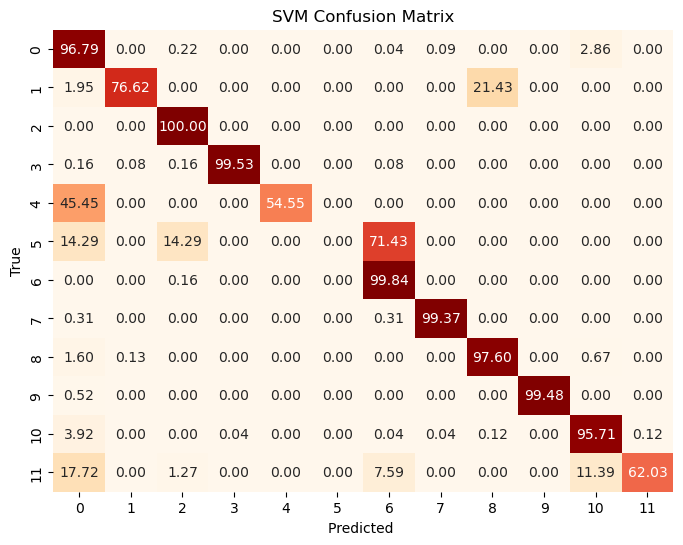

In [9]:
#Isolate kernel = Poly since we know that it is the best accuracy
svc_poly = SVC(kernel= 'poly')
svc_poly.fit(X_train, y_train)
y_pred = svc_poly.predict(X_test)
    
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

#confusion matrix 
cm_ada_cv = confusion_matrix(y_test, y_pred)
#making it percent
cm_percent_ada_cv = cm_ada_cv / np.sum(cm_ada_cv, axis=1, keepdims=True) * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent_ada_cv, annot=True,cmap= 'OrRd' ,fmt=".2f", cbar=False)
plt.xlabel('Predicted ')
plt.ylabel('True')
plt.title('SVM Confusion Matrix')
savefig("SVM_CM.png")

Accuracy: 0.9947205977907733
                            precision    recall  f1-score   support

            ARP_poisioning       0.96      0.98      0.97      2306
            DDOS_Slowloris       0.99      0.76      0.86       154
             DOS_SYN_Hping       1.00      1.00      1.00     28409
              MQTT_Publish       1.00      1.00      1.00      1273
Metasploit_Brute_Force_SSH       0.86      0.55      0.67        11
             NMAP_FIN_SCAN       0.60      0.86      0.71         7
         NMAP_OS_DETECTION       1.00      1.00      1.00       622
             NMAP_TCP_scan       0.99      0.99      0.99       319
             NMAP_UDP_SCAN       0.95      0.98      0.97       750
       NMAP_XMAS_TREE_SCAN       1.00      0.99      1.00       582
               Thing_Speak       0.98      0.98      0.98      2424
                Wipro_bulb       0.94      0.86      0.90        79

                  accuracy                           0.99     36936
                 

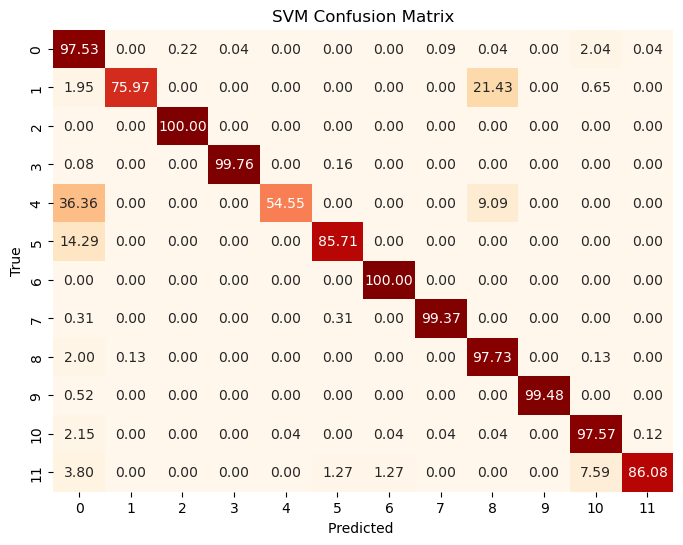

In [10]:
## testing a different gamma 
svc_poly = SVC(kernel= 'poly', gamma = 'auto')
svc_poly.fit(X_train, y_train)
y_pred = svc_poly.predict(X_test)
    
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

#confusion matrix 
cm_ada_cv = confusion_matrix(y_test, y_pred)
#making it percent
cm_percent_ada_cv = cm_ada_cv / np.sum(cm_ada_cv, axis=1, keepdims=True) * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent_ada_cv, annot=True,cmap= 'OrRd' ,fmt=".2f", cbar=False)
plt.xlabel('Predicted ')
plt.ylabel('True')
plt.title('SVM Confusion Matrix')
savefig("SVM_CM.png")

# Combine to 2 classes for hyperplane graph -- Emily

below is an attempt at visualizing the hyperplane -- did not work out because we have too many features

In [ ]:
#map classes to integers
def attack_type(y):
    new_class = []
    for i in range (0, len(y)):
        if ((y.iloc[i] == 'MQTT_Publish') or (y.iloc[i] == 'Thing_Speak') or (y.iloc[i] == 'Wipro_bulb')):
            #new_class.append('Normal')
            new_class.append(0)
        else:
            new_class.append(1) #new_class.append('Attack')
    return new_class

In [16]:
new_class = np.array(attack_type(data['Attack_type']))

In [17]:
data['Attack Class'] = new_class

In [18]:
# Identify columns with a single unique value
single_value_columns = data.nunique()
single_value_columns = single_value_columns[single_value_columns <= 1].index.tolist()

# Potentially irrelevant columns
potentially_irrelevant_columns = single_value_columns  # 'Unnamed: 0' seems like an identifier

# Remove the identified irrelevant columns
cleaned_data = data.drop(columns=potentially_irrelevant_columns)

# Display the first few rows of the cleaned dataset to confirm removal
cleaned_data.head()

,id.orig_p,id.resp_p,proto,service,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,...,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,Attack_type,Attack Class
0,38667,1883,tcp,mqtt,32.011598,9,5,3,3,0.281148,...,29729182.96,29729182.96,29729182.96,29729182.96,0.0,64240,26847,502,MQTT_Publish,0
1,51143,1883,tcp,mqtt,31.883584,9,5,3,3,0.282277,...,29855277.06,29855277.06,29855277.06,29855277.06,0.0,64240,26847,502,MQTT_Publish,0
2,44761,1883,tcp,mqtt,32.124053,9,5,3,3,0.280164,...,29842149.02,29842149.02,29842149.02,29842149.02,0.0,64240,26847,502,MQTT_Publish,0
3,60893,1883,tcp,mqtt,31.961063,9,5,3,3,0.281593,...,29913774.97,29913774.97,29913774.97,29913774.97,0.0,64240,26847,502,MQTT_Publish,0
4,51087,1883,tcp,mqtt,31.902362,9,5,3,3,0.282111,...,29814704.90,29814704.90,29814704.90,29814704.90,0.0,64240,26847,502,MQTT_Publish,0


In [19]:
data_encoded = pd.get_dummies(cleaned_data, columns=['proto', 'service'])

# Assuming `data_encoded` now holds fully numerical dataset
X = data_encoded.drop(['Attack_type', 'Attack Class'], axis=1)  # Exclude the target variable for PCA
y = data_encoded['Attack Class']  # This assumes `Attack_type` has been properly converted to numerical format

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=0.95)  # Adjust based on desired variance retention
X_pca = pca.fit_transform(X_scaled)


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

X = X_train[:, :2]
y = y_train

In [21]:
from sklearn.svm import SVC

def plot_training_data_with_decision_boundary(kernel):
    # Train the SVC
    clf = SVC(kernel=kernel, gamma= 'auto').fit(X, y)

    # Settings for plotting
    _, ax = plt.subplots(figsize=(4, 3))
    x_min, x_max, y_min, y_max = -3, 3, -3, 3
    ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))

    # Plot decision boundary and margins
    common_params = {"estimator": clf, "X": X, "ax": ax}
    DecisionBoundaryDisplay.from_estimator(
        **common_params,
        response_method="predict",
        plot_method="pcolormesh",
        alpha=0.3,
    )
    DecisionBoundaryDisplay.from_estimator(
        **common_params,
        response_method="decision_function",
        plot_method="contour",
        levels=[-1, 0, 1],
        colors=["k", "k", "k"],
        linestyles=["--", "-", "--"],
    )

    # Plot bigger circles around samples that serve as support vectors
    ax.scatter(
        clf.support_vectors_[:, 0],
        clf.support_vectors_[:, 1],
        s=250,
        facecolors="none",
        edgecolors="k",
    )
    # Plot samples by color and add legend
    ax.scatter(X[:, 0], X[:, 1], c=y, s=150, edgecolors="k")
    ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
    ax.set_title(f" Decision boundaries of {kernel} kernel in SVC")

    _ = plt.show()

In [ ]:
plot_training_data_with_decision_boundary('poly')